In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm
import datetime
import random

# importar funções de outro arquivo, fazer nesse padrao:
# pular 2 linhas do resto das importações 

In [2]:
from objects import VarMask, Portfolio, Instrument
from utils import *

### Montando um portfólio contendo posições em futuros de ouro (GC=F) e de dólar (DX=F).

In [3]:
time_horizon = 126 #período dos últimos 6 meses

ativos = [
    "PETR4.SA", # Petrobrás
    "VALE3.SA", # Vale
    "ITUB4.SA", # Itaú
    "BBDC4.SA", # Bradesco
    "ABEV3.SA"  # Ambev
] 

#fechamento_carteira é um Dataframe de preços de fechamento de cada ativo em cada dia
fechamento_carteira = yf.download(ativos, period="6mo", interval="1d")['Close']

/var/folders/0d/c4xc2yx94tvd453tjjr9trt00000gn/T/ipykernel_3183/2548809900.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  fechamento_carteira = yf.download(ativos, period="6mo", interval="1d")['Close']
[*********************100%***********************]  5 of 5 completed


In [4]:
var_mask = VarMask(time_horizon=252, confidence_level=0.99)

## Gerador de posições do portifolio

In [5]:
random.seed(0)
posicoes = {}
for ticker in ativos:
    posicao = random.randint(0,100)
    posicoes[ticker] = posicao

portfolio = Portfolio(quantities_dict=posicoes, instruments=dataframe_to_instruments(fechamento_carteira))

In [6]:
x = portfolio.value_portfolio()
print(x)

{datetime.date(2025, 2, 3): np.float64(8737.625147819519), datetime.date(2025, 2, 4): np.float64(8703.850957870483), datetime.date(2025, 2, 5): np.float64(8740.309390068054), datetime.date(2025, 2, 6): np.float64(8818.448410987854), datetime.date(2025, 2, 7): np.float64(8766.66522026062), datetime.date(2025, 2, 10): np.float64(8852.227944374084), datetime.date(2025, 2, 11): np.float64(8847.193598747253), datetime.date(2025, 2, 12): np.float64(8739.531024932861), datetime.date(2025, 2, 13): np.float64(8758.810664176941), datetime.date(2025, 2, 14): np.float64(8933.649390220642), datetime.date(2025, 2, 17): np.float64(8918.622591018677), datetime.date(2025, 2, 18): np.float64(8982.174250602722), datetime.date(2025, 2, 19): np.float64(8961.523550987244), datetime.date(2025, 2, 20): np.float64(9153.530191421509), datetime.date(2025, 2, 21): np.float64(9184.939646720886), datetime.date(2025, 2, 24): np.float64(9110.439144134521), datetime.date(2025, 2, 25): np.float64(9068.588623046875), da

### Volatilidade é o StDev[retorno]

### Anualização da Volatilidade


Ao somar \(T\) dias independentes a variância total é:
   $$
   \mathrm{Var}\Bigl(\sum_{t=1}^{T} r_t\Bigr)
   \;=\;
   T \times \sigma^2.
   $$


   $$
   \sigma_{T}
   \;=\;
   \sqrt{\mathrm{Var}(r_1 + \dots + r_T)}
   \;=\;
   \sqrt{T \times \sigma^2}
   \;=\;
   \sqrt{T}\;\sigma.
   $$

Para os 252 dias de pregão.

In [7]:
#volatilidade anualizada
vol_anualiz = vol_instrument(portfolio.instruments['ABEV3.SA'])
vol_anualiz

{'ABEV3.SA': np.float64(0.23239529222113078)}

In [8]:
var_instrument = var_by_instrument(portfolio=portfolio, mask=var_mask)
print(var_instrument)

{'ABEV3.SA': np.float64(219.2642387952722), 'BBDC4.SA': np.float64(57.85196170926167), 'ITUB4.SA': np.float64(880.6319613638123), 'PETR4.SA': np.float64(948.685367625571), 'VALE3.SA': np.float64(3082.4495234732867)}


In [9]:
var = var_carteira(portfolio=portfolio, mask=var_mask)
print(var)


5188.883052967204


## Como estamos pressupondo uma distribuição normal, o retorno percentual ~ N(média, var), bastam estimativas para o retorno médio do ativo que se quer calcular o VaR bem como de seu desvio-padrão.

In [10]:
#pela tabela da normal, apenas 5% dos valores estão abaixo da 
#média - 1.65 * desvio-padrão. 
var = abs(media_dia - 1.65 *std_dia)
print(f'Assim com 95%, o VaR (percentual) é de {var}% do valor investido.')

NameError: name 'media_dia' is not defined

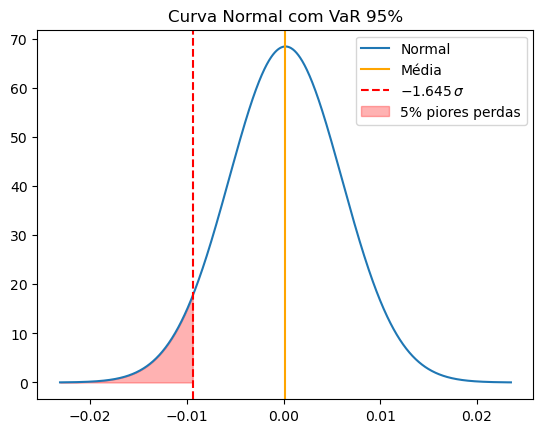

À esquerda da linha vermelha estão os 5% piores saltos (as maiores perdas). 
Com 95% de confiança, a perda diária não será pior que 0.009415754485442018% do valor investido.


In [ ]:
x = np.linspace(media_dia - 4*std_dia,
                media_dia + 4*std_dia,
                1000)
y = norm.pdf(x, loc=media_dia, scale=std_dia)

plt.plot(x, y, label='Normal')
plt.axvline(media_dia, color='orange', label='Média')

# locais dos quantis para VaR 95%
quantil  = media_dia + norm.ppf(0.05) * std_dia   # = media - 1.645*std

# marcar com linha vertical 
plt.axvline(quantil,  color='red',   linestyle='--', label=r'$-1.645\,\sigma$')

plt.fill_between(x, y, where=(x<=quantil), color='red', alpha=0.3,
                 label='5% piores perdas')


plt.title('Curva Normal com VaR 95%')
plt.legend()
plt.show()

print(f'À esquerda da linha vermelha estão os 5% piores saltos (as maiores perdas). \nCom 95% de confiança, a perda diária não será pior que {var}% do valor investido.')

## Montar gráfico de porcentagem de contribuição do ativo para o var.



## Correlação entre os ativos.

In [ ]:
matriz_corr = retornos.corr()
corr = matriz_corr.iloc[0,1]

print(f'Os ativos tem correlação = {corr} indicando uma forte Correlação Negativa.')


Os ativos tem correlação = -0.5780934814438673 indicando uma forte Correlação Negativa.


## Olhando para a série histórica de preços.

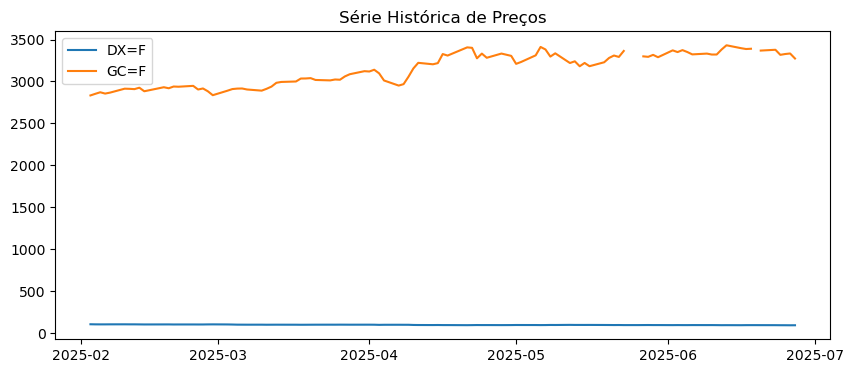

In [ ]:
import matplotlib.pyplot as plt

# exemplo com dois ativos
fig, ax = plt.subplots(figsize=(10,4))
for col in [fechamento_carteira.columns]:
    ax.plot(fechamento_carteira[col], label=col)
ax.set_title("Série Histórica de Preços")
ax.legend()
plt.show()


### Como a diferença de valores é muito grande, vamos normalizar para ter uma melhor visualização.

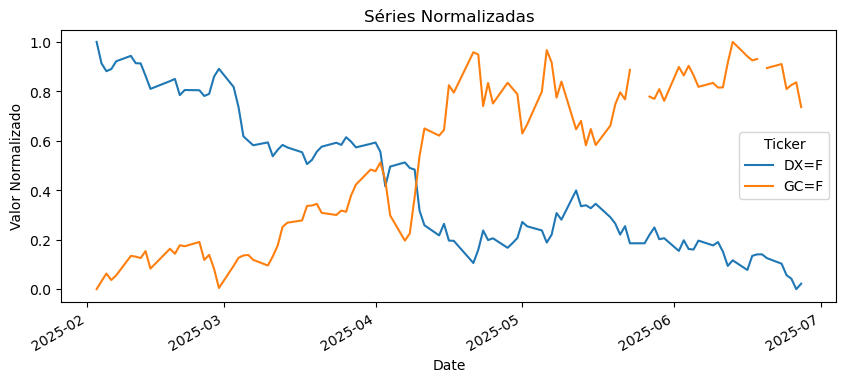

In [ ]:
# normalização: (X - Xmin)/(Xmax - Xmin)
# todos os valores estarão entre [0,1], assim conseguiremos observar melhor a movimentação dos preços.
norm = (fechamento_carteira - fechamento_carteira.min()) / (fechamento_carteira.max() - fechamento_carteira.min())

norm.plot(figsize=(10,4))
plt.title('Séries Normalizadas')
plt.ylabel('Valor Normalizado')
plt.show()
